In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
print(torch.__version__)

2.4.1+cu121


Device Agnostic Code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
image, label = train_data[2]
image.shape, label

(torch.Size([1, 28, 28]), 4)

In [6]:
class_name = train_data.classes
class_name

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

(-0.5, 27.5, 27.5, -0.5)

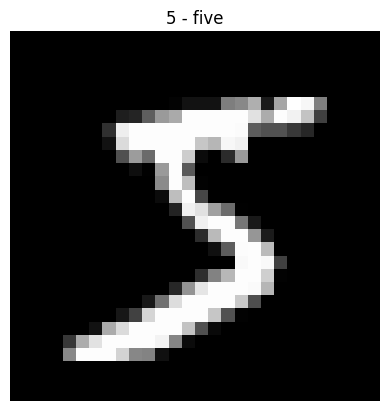

In [8]:
image, label = train_data[0]
plt.imshow(image.squeeze(),cmap='gray')
plt.title(class_name[label])
plt.axis(False)

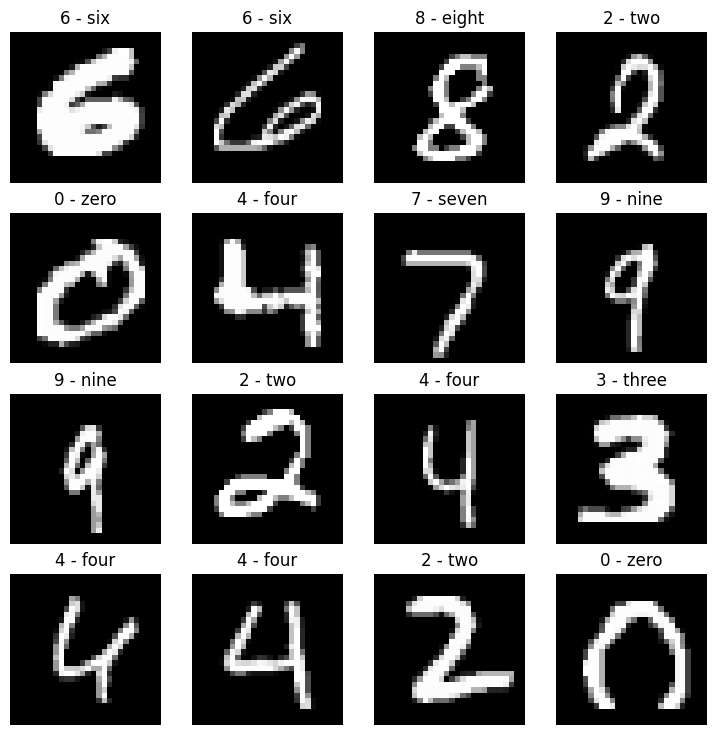

In [9]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
row,cols = 4,4
for i in range(1,row*cols+1):
  random_idx = torch.randint(0,len(train_data),(1,)).item()
  image, label = train_data[random_idx]
  fig.add_subplot(row,cols,i)
  plt.imshow(image.squeeze(),cmap="gray")
  plt.title(class_name[label])
  plt.axis(False)

In [10]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              shuffle = False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [11]:
len(train_dataloader), len(test_dataloader)

(1500, 313)

In [12]:
train_feature_batch, train_label_batch = next(iter(train_dataloader))
train_feature_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

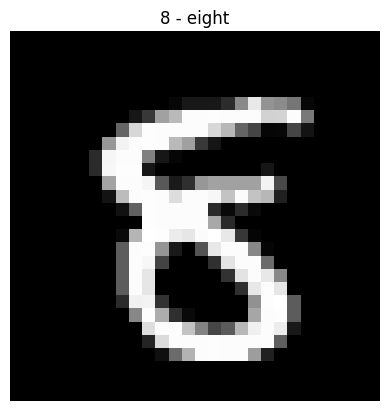

In [13]:
plt.imshow(train_feature_batch[0].squeeze(),cmap='gray')
plt.title(class_name[train_label_batch[0]])
plt.axis(False)

In [14]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# ANN Model


In [15]:
class MNISTModelV0(nn.Module):
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()
    self.layer_1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_shape)
      )
  def forward(self,x):
    return self.layer_1(x)

In [16]:
model_0 = MNISTModelV0(input_shape=784,hidden_units=10,output_shape=10).to(device)

In [17]:
train_loss_count = []
def train_step(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               accuracy_fn, device:torch.device = device):

  train_loss, train_acc = 0,0
  model.train()

  for batch,(X,y) in enumerate(data_loader):

    X,y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss
    train_acc+= accuracy_fn(y_true=y,
                            y_pred = y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  train_loss_count.append(train_loss)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

def test_step(model:torch.nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

  test_loss, test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred,y)
      test_acc += accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim =1)) # logits to prediction labels

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
  print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")


In [18]:
validation_loss_count = []
def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()
            total_correct += (y_pred.argmax(dim=1) == y).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_correct / len(dataloader.dataset)
    validation_loss_count.append(avg_loss)
    avg_accuracy = avg_accuracy * 100
    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {avg_accuracy:.2f}%")


### Training

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [20]:
from tqdm.auto import tqdm
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_step(model=model_0,
             data_loader=train_dataloader,
             loss_fn = loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device = device)
  test_step(model=model_0,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.58597 | Train acc: 81.43%
Test loss: 0.40594 | Test acc: 88.03%

Epoch: 1
---------
Train loss: 0.31627 | Train acc: 90.59%
Test loss: 0.28850 | Test acc: 91.19%

Epoch: 2
---------
Train loss: 0.27465 | Train acc: 91.75%
Test loss: 0.25563 | Test acc: 92.28%



### Evaluation of current model

In [21]:
def eval_model(model:torch.nn.Module,data_loader: torch.utils.data.DataLoader,loss_fn: torch.nn.Module, accuracy_fn, device = device):

  loss,acc = 0,0
  model.eval()

  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      X ,y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred,y)
      acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name":model.__class__.__name__,"model_loss":loss.item(),"model_acc":acc}


model_0_results = eval_model(model=model_0,
           data_loader=test_dataloader,
           loss_fn=loss_fn,
           accuracy_fn=accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [22]:
model_0_results

{'model_name': 'MNISTModelV0',
 'model_loss': 0.2556251287460327,
 'model_acc': 92.28234824281151}

In [23]:
def make_prediction(model:torch.nn.Module,
                    data:list,
                    device:torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample,dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)

      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)


In [24]:
import random
random.seed(42)
test_samples =[]
test_labels = []
for sample, label in random.sample(list(test_data),k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, '2 - two')

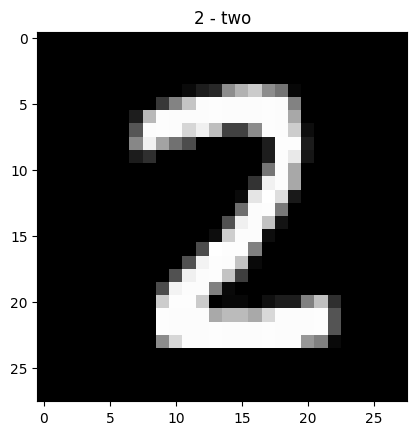

In [25]:
plt.imshow(test_samples[0].squeeze(),cmap = "gray")
plt.title(class_name[test_labels[0]])

In [26]:
pred_probs = make_prediction(model=model_0,data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

In [27]:
test_labels

[2, 1, 2, 4, 6, 6, 4, 9, 1]

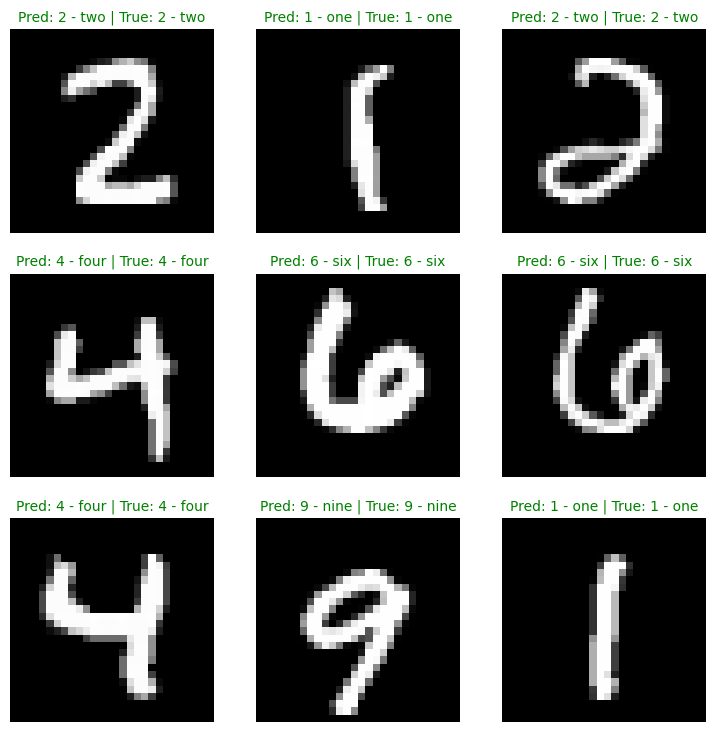

In [28]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):

  plt.subplot(nrows,ncols,i+1)

  plt.imshow(sample.squeeze(),cmap = "gray")

  pred_label = class_name[pred_classes[i]]

  true_label = class_name[test_labels[i]]

  title_test = f"Pred: {pred_label} | True: {true_label}"

  if pred_label == true_label:
    plt.title(title_test,c="g",fontsize = 10)
  else:
    plt.title(title_test,c="r",fontsize = 10)

  plt.axis(False)

In [29]:
!pip install torchmetrics

In [30]:
import torchmetrics
import numpy as np
f1 = torchmetrics.F1Score(num_classes=10, average='macro',task='multiclass')
f1 = f1.to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=10)
confusion_matrix = confusion_matrix.to(device)

In [31]:
all_preds = []
all_labels = []

model_0.eval()
with torch.inference_mode():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_0(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(probabilities, 1)

        all_preds.append(predicted.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        f1.update(predicted, labels)
        confusion_matrix.update(predicted, labels)

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
cm = confusion_matrix.compute().cpu().numpy()
final_f1 = f1.compute()
print(f'F1 Score: {final_f1:.4f}')
print(f'Confusion Matrix:\n{cm}')
f1.reset()

F1 Score: 0.9214
Confusion Matrix:
[[ 954    0    7    1    0    3   12    1    2    0]
 [   0 1102   13    2    0    0    5    6    7    0]
 [   5    4  971    2   10    4   17   11    5    3]
 [   0    0   38  912    1   28    2   13   10    6]
 [   0    1    7    0  946    0   18    1    1    8]
 [  14    5   14   44    5  745   31    1   22   11]
 [   8    2    6    0    7    5  929    0    1    0]
 [   4   11   20    3   10    1    0  955    0   24]
 [   6    7   18    5   13    9   37    6  860   13]
 [   3    5    5   10  103    8    0   14    7  854]]


In [32]:
#using mlxtend for better confusion matrix
from mlxtend.plotting import plot_confusion_matrix

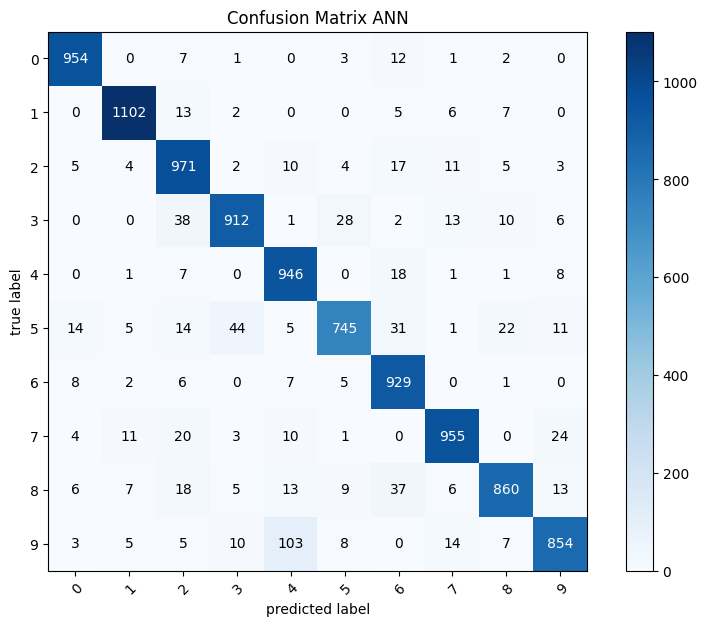

In [33]:
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(10,7), colorbar=True, class_names=range(10))

plt.title('Confusion Matrix ANN')
plt.show()

#CNN for Recognition


In [34]:
class MNISTModelV1(nn.Module):
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
    self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

  def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

### Training

In [35]:
model_1 = MNISTModelV1(input_shape=1,hidden_units=10,output_shape=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),lr=0.001)
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [36]:
epochs = 10
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch+1}\n-------")
  train_step(model_1,
             train_dataloader,
             loss_fn,
             optimizer,
             accuracy_fn,
             device)
  test_step(model_1,
            test_dataloader,
            loss_fn,
            accuracy_fn,
            device)
  validate(model_1, test_dataloader, loss_fn, device)
  scheduler.step()


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-------
Train loss: 0.24015 | Train acc: 92.38%
Test loss: 0.08239 | Test acc: 97.17%

Validation Loss: 0.0824, Validation Accuracy: 97.17%
Epoch: 2
-------
Train loss: 0.08231 | Train acc: 97.41%
Test loss: 0.05861 | Test acc: 98.24%

Validation Loss: 0.0586, Validation Accuracy: 98.24%
Epoch: 3
-------
Train loss: 0.05036 | Train acc: 98.50%
Test loss: 0.04418 | Test acc: 98.58%

Validation Loss: 0.0442, Validation Accuracy: 98.58%
Epoch: 4
-------
Train loss: 0.04587 | Train acc: 98.58%
Test loss: 0.04192 | Test acc: 98.59%

Validation Loss: 0.0419, Validation Accuracy: 98.59%
Epoch: 5
-------
Train loss: 0.04171 | Train acc: 98.73%
Test loss: 0.04117 | Test acc: 98.67%

Validation Loss: 0.0412, Validation Accuracy: 98.67%
Epoch: 6
-------
Train loss: 0.04119 | Train acc: 98.77%
Test loss: 0.04113 | Test acc: 98.68%

Validation Loss: 0.0411, Validation Accuracy: 98.68%
Epoch: 7
-------
Train loss: 0.04067 | Train acc: 98.77%
Test loss: 0.04106 | Test acc: 98.68%

Validation

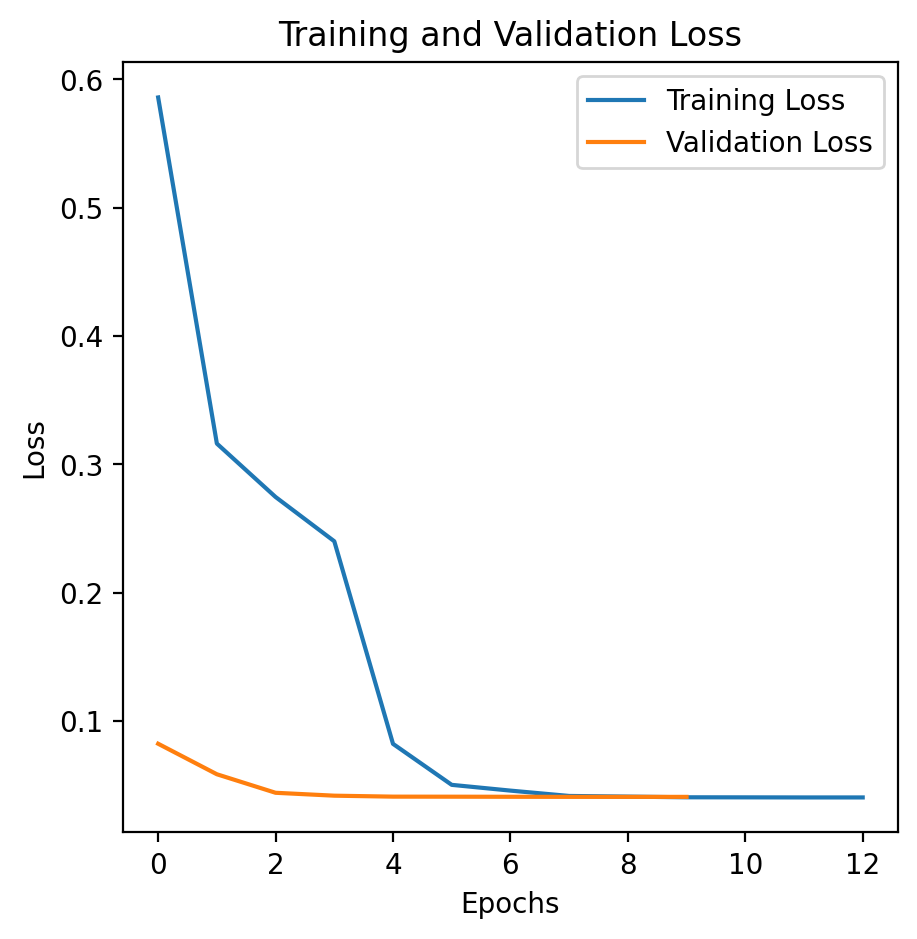

In [37]:
train_loss_count_np = np.array([loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_loss_count])
validation_loss_count_np = np.array([loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in validation_loss_count])

plt.figure(figsize=(5, 5), dpi=200)
plt.plot(train_loss_count_np, label='Training Loss')
plt.plot(validation_loss_count_np, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()


###Evaluation


In [38]:
model_1_results = eval_model(model_1,test_dataloader,loss_fn,accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'MNISTModelV1',
 'model_loss': 0.04098644480109215,
 'model_acc': 98.69209265175719}

In [39]:
import random
random.seed(42)
test_samples_cnn =[]
test_labels_cnn = []
for sample, label in random.sample(list(test_data),k=9):
  test_samples_cnn.append(sample)
  test_labels_cnn.append(label)

test_samples_cnn[0].shape

torch.Size([1, 28, 28])

In [40]:
pred_probs_cnn = make_prediction(model=model_1,data=test_samples_cnn)
pred_classes_cnn = pred_probs.argmax(dim=1)
pred_classes_cnn

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

In [41]:
test_labels_cnn

[2, 1, 2, 4, 6, 6, 4, 9, 1]

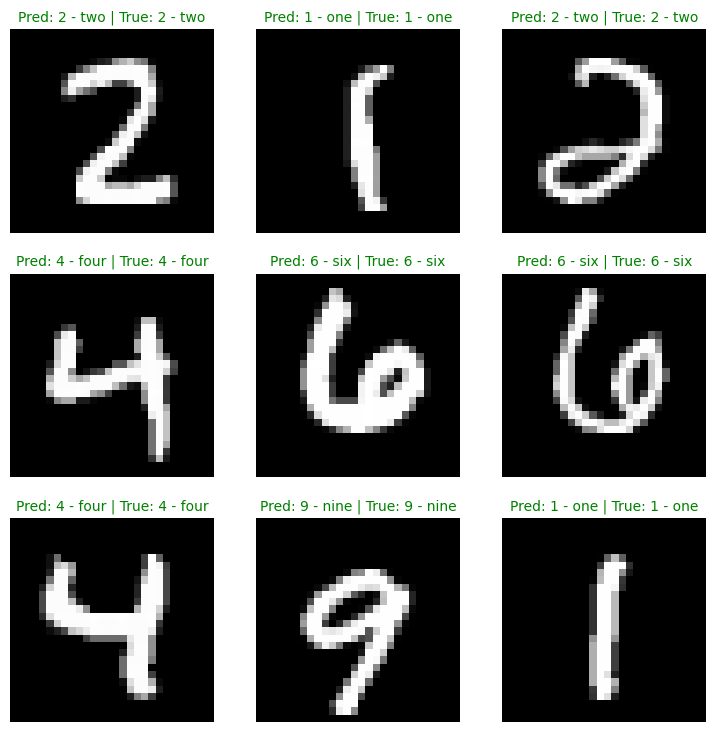

In [42]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples_cnn):
  plt.subplot(nrows,ncols,i+1)
  plt.imshow(sample.squeeze(),cmap = "gray")
  pred_label = class_name[pred_classes_cnn[i]]
  true_label = class_name[test_labels_cnn[i]]
  title_test = f"Pred: {pred_label} | True: {true_label}"
  if pred_label == true_label:
    plt.title(title_test,c="g",fontsize = 10)
  else:
    plt.title(title_test,c="r",fontsize = 10)
  plt.axis(False)

In [43]:
all_preds_cnn = []
all_labels_cnn = []

model_1.eval()
with torch.inference_mode():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_1(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(probabilities, 1)

        all_preds_cnn.append(predicted.cpu().numpy())
        all_labels_cnn.append(labels.cpu().numpy())

        f1.update(predicted, labels)
        confusion_matrix.update(predicted, labels)

all_preds_cnn = np.concatenate(all_preds_cnn)
all_labels_cnn = np.concatenate(all_labels_cnn)
cm_cnn = confusion_matrix.compute().cpu().numpy()
final_f1 = f1.compute()
print(f'F1 Score: {final_f1:.4f}')
print(f'Confusion Matrix:\n{cm}')
f1.reset()

F1 Score: 0.9869
Confusion Matrix:
[[ 954    0    7    1    0    3   12    1    2    0]
 [   0 1102   13    2    0    0    5    6    7    0]
 [   5    4  971    2   10    4   17   11    5    3]
 [   0    0   38  912    1   28    2   13   10    6]
 [   0    1    7    0  946    0   18    1    1    8]
 [  14    5   14   44    5  745   31    1   22   11]
 [   8    2    6    0    7    5  929    0    1    0]
 [   4   11   20    3   10    1    0  955    0   24]
 [   6    7   18    5   13    9   37    6  860   13]
 [   3    5    5   10  103    8    0   14    7  854]]


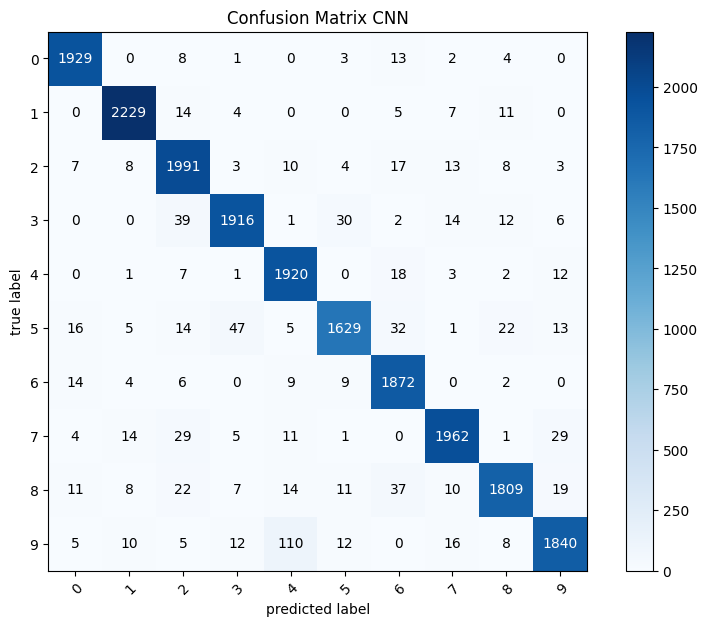

In [44]:
fig, ax = plot_confusion_matrix(conf_mat=cm_cnn, figsize=(10,7), colorbar=True, class_names=range(10))

plt.title('Confusion Matrix CNN')
plt.show()

In [45]:
import pandas as pd
results = pd.DataFrame([model_0_results,model_1_results])
results

,model_name,model_loss,model_acc
0,MNISTModelV0,0.255625,92.282348
1,MNISTModelV1,0.040986,98.692093
